In [1]:
#from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, quantum_info, execute, transpile, assemble, IBMQ
#from qiskit.circuit import Gate
#from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
#from qiskit.quantum_info import Statevector,random_statevector
#from qiskit.extensions import Initialize
#from qiskit.tools.monitor import job_monitor
#from qiskit.visualization import array_to_latex
#from qiskit.providers.ibmq import least_busy

from qiskit import *
from qiskit.visualization import *
from qiskit.quantum_info import *
from qiskit.extensions import *
from qiskit.tools.monitor import *
from qiskit.providers.ibmq import *
from qiskit.circuit import *

import numpy as np
import matplotlib as mpl

from ipywidgets import interactive
from IPython.core.display import display

#%config InlineBackend.figure_format = 'retina' #si tenéis pantalla retina (creo que más de 144ppp)las figuras salen
#con mejor definición con este comando. Si no teneis, usad el comando de abajo pero va a cambiar el tamaño de todo.
mpl.rcParams['figure.dpi'] = 50 

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 18 09:15:21 2022

@author: xowy
"""
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex


##############################################################################
# Definimos funciones auxiliares para printear

def MatrixToLatex(A):
    a = "\\begin{pmatrix}"
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if ((j+1) % A.shape[1]) == 0:
                a = a+"{0:.2f}".format(A[i, j])
            else:
                a = a+"%s&" % "{0:.2f}".format(A[i, j])
        if ((i+1) % A.shape[0]) != 0:
            a = a+"\\\\"
    a = a+"\\end{pmatrix}"
    return(a)


def Display(string):
    display(Markdown(string))

In [3]:
IBMQ.save_account('690f441b74197a4d72968214bf5d7c446e999c114dcf7247f821a9604c4ac2d1136815105e210fc44485bd885148d815e441135c43f7bc7668195a5911f6cb01', overwrite=True)

# Estado de Bell |B00>

In [4]:
def estado_bell(qc, a, b):
    """Creamos una función que crea un estado de Bell. De este par entrelazado, Alice tendrá un qubit 
    y Bob el otro."""
    qc.h(a) # La puerta H pone el cubit a en |+>
    qc.cx(a,b)

# Teleportación Cuántica

<img src="./Imagenes_repaso/teleportacion.png" width="700"/>

Bits que Alice envia  || Operación de Bob
--------  || :--------:
00  || $\operatorname{I}$ 
01  || $\operatorname{X}$ 
10  || $\operatorname{Z}$ 
11  || $\operatorname{ZX}$ 

## Alice 

In [5]:
def accion_alice(qc, psi, a):
    qc.cx(psi, a) #Se aplica una CNOT controlada por psi sobre a
    qc.h(psi) # Se aplica una H sobre psi
    
def medida(qc, a, b):
    qc.measure(a,0)
    qc.measure(b,1)

## Bob

In [6]:
"""Aquí, crz y crx son los registros clásicos en función de los cuales se aplican unas puertas u otras."""
def accion_bob(qc, qubit, crz, crx):
    """c_if controla las puertas con un bit clásico en vez de con un cubit"""
    qc.x(qubit).c_if(crx, 1) # Estas dos líneas verifican
    qc.z(qubit).c_if(crz, 1) # las acciones vistas arriba.

## Circuito

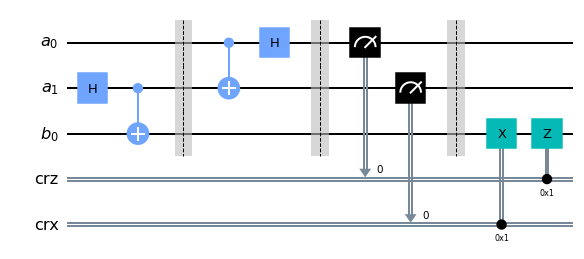

In [7]:
#qr = QuantumRegister(3, name=["q"])
qr1 = QuantumRegister(2,name="a")
qr2 = QuantumRegister(1,name="b")
crz = ClassicalRegister(1, name="crz") 
crx = ClassicalRegister(1, name="crx") 
qc = QuantumCircuit(qr1,qr2, crz, crx)

estado_bell(qc, 1, 2)

qc.barrier() 
accion_alice(qc, 0, 1)

qc.barrier()
medida(qc, 0, 1)

qc.barrier()
accion_bob(qc, 2, crz, crx)
qc.draw(output='mpl')

## Estado $\lvert \psi \rangle$ a transportar

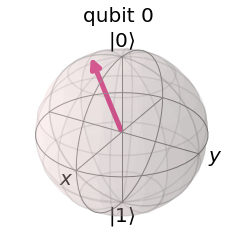

In [8]:
# Se crea un cubit random que luego se quiere teleportar
psi = random_statevector(2)
# Lo representamos en la esfera de Bloch
display(plot_bloch_multivector(psi))
init_gate = Initialize(psi) #Esta función nos permite meter el estado en q_{0}
init_gate.label = "psi"

## Circuito con el estado $\lvert \psi \rangle$ incial implementado

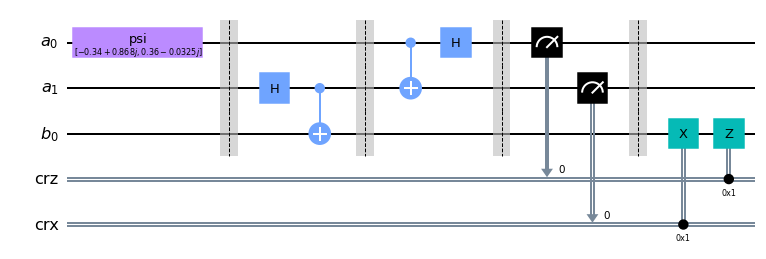

In [9]:
qr1 = QuantumRegister(2,name="a")
qr2 = QuantumRegister(1,name="b")
crz = ClassicalRegister(1, name="crz") 
crx = ClassicalRegister(1, name="crx") 
qc = QuantumCircuit(qr1,qr2, crz, crx)
# Este primer paso inicializa el estado q_{0} en el que hemos generado de forma random y que se va a teleportar
qc.append(init_gate, [0])
qc.barrier()
# Aplicamos el circuito que ya se presentó antes
estado_bell(qc, 1, 2)
qc.barrier()
accion_alice(qc, 0, 1)
qc.barrier()
medida(qc, 0, 1)
qc.barrier()
accion_bob(qc, 2, crz, crx)
qc.draw(output='mpl')

## Resultado

### Como statevector

In [10]:
backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend)
outputstate = job.result().get_statevector()
print(outputstate)

[-0.        +0.j         -0.34006314+0.86835741j  0.        +0.j
 -0.        +0.j         -0.        +0.j          0.35952175-0.03250512j
  0.        -0.j          0.        -0.j        ]


### En la esfera de Bloch 

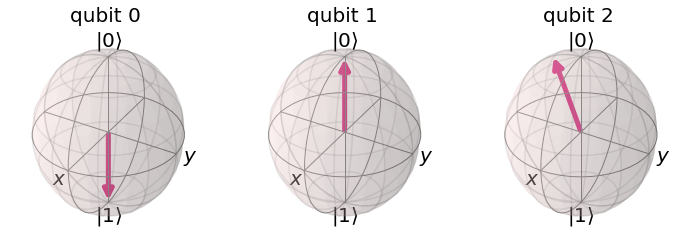

In [11]:
sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
out_vector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(out_vector)

## Circuito alternativo, sin implementar la retro-medida clásica

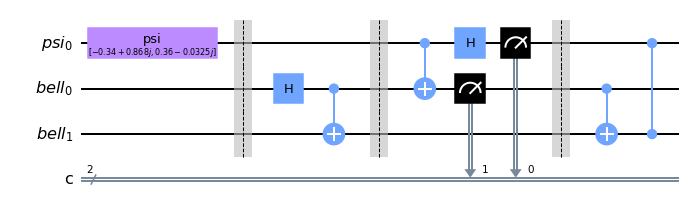

In [12]:
psi = QuantumRegister(1, name  = 'psi')  # The qubit to teleport
bell = QuantumRegister(2, name = 'bell') # The shared entangled pair 
c = ClassicalRegister(2, name  = 'c') # Two classical bits for the measures

teleport = QuantumCircuit(psi,bell,c) # We create the circuit with the two quantum registers and the classical bits
#teleport.initialize([c1,c2],psi)
teleport.append(init_gate, [0]) # We set the amplitudes for Alice's quibt
teleport.barrier()

# Now we create the Bell pair

teleport.h(bell[0])
teleport.cx(bell[0],bell[1])
teleport.barrier()

# We apply CNOT to |psi> and Alice's part of the entangled pair
# We also apply the H gate
# Then, Alice measure her qubits and send the results to Bob

teleport.cx(psi,bell[0])
teleport.h(psi)
teleport.measure([psi[0],bell[0]],c)
teleport.barrier()

# Bob applies his gates depending on the values received from Alice 

teleport.cx(bell[0],bell[1])
teleport.cz(psi,bell[1])

teleport.draw(output='mpl')

# Codificación Densa

<center><img src="Imagenes_repaso/codifdensa.png" width='700' height='160'/><center>

Bits que Alice envia | Operación | Estado resultante que Bob va a recibir
-------- | ------- | :--------:
00 | $\operatorname{I}$ | $\left|\Psi_{1}(00)\right\rangle=\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$
01 | $\operatorname{Z}$ | $\left|\Psi_{1}(01)\right\rangle=\frac{1}{\sqrt{2}}(|00\rangle-|11\rangle)$
10 | $\operatorname{X}$ | $\left|\Psi_{1}(10)\right\rangle=\frac{1}{\sqrt{2}}(|10\rangle+|01\rangle)$
11 | $\operatorname{iY}$ | $\left|\Psi_{1}(11)\right\rangle=\frac{1}{\sqrt{2}}(|01\rangle-|10\rangle)$

Mensaje a enviar: 10


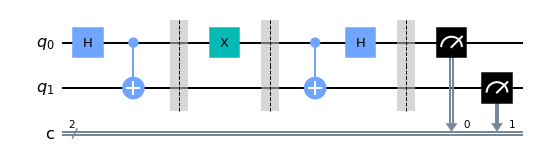

In [13]:
mensajes = ['00', '01', '10', '11']
mensaje = np.random.choice(mensajes)
print('Mensaje a enviar:',mensaje)

qc = QuantumCircuit(2, 2)

"""En el primer caso Alice desea enviar 00, para lo cual la operación a aplicar es la identidad. 
Estas líneas crean el estado de Bell.
"""
qc.h(0)
qc.cx(0, 1)
qc.barrier()

# En el resto de casos, se hace necesario añadir las puertas de la celda anterior.
if mensaje == '01':
    qc.z(0)
    qc.barrier()
    
elif mensaje == '10':
    qc.x(0)
    qc.barrier()
    
elif mensaje == '11':
    qc.unitary(iY_op, [0], label='iY')
    qc.barrier()


qc.cx(0, 1)
qc.h(0)
qc.barrier()

qc.measure([0, 1], [0, 1])
qc.draw(output='mpl')

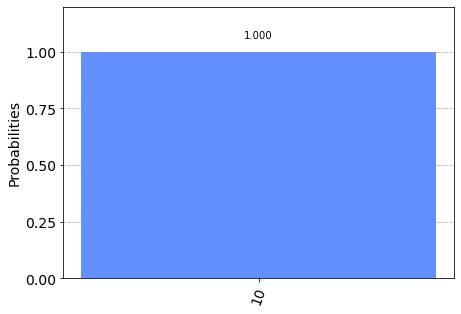

In [14]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)

In [15]:
shots = 1024

# Cargamos nuestra información personal de la cuenta que hemos creado de IBM

#IBMQ.save_account()
IBMQ.load_account()
# Escogemos el backend que esté (más) libre. Este es el paso que puede tardar varios minutos por temas de cola.
provider = IBMQ.get_provider(hub='ibm-q')

backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
#Para un ordenador que tenga un mayor número de cubits esperamos que el resultado sea mejor
"""
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 5
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
"""
print("least busy backend: ", backend)
t_qc = transpile(qc, backend, optimization_level=3)
job_exp = backend.run(t_qc)

least busy backend:  ibmq_lima


In [18]:
job_monitor(job_exp)

Job Status: job has successfully run


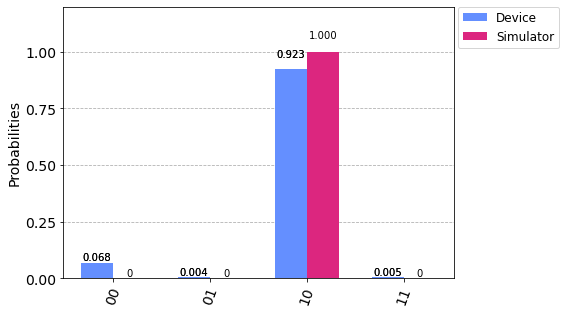

In [17]:
result_exp = job_exp.result()
counts_exp = result_exp.get_counts(qc)
plot_histogram([counts_exp,counts], legend=['Device', 'Simulator'])